# Solute transport in uniform background flow

In [1]:
# imports used across the examples
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Initial conditions

## Superposition

### In space

### In time

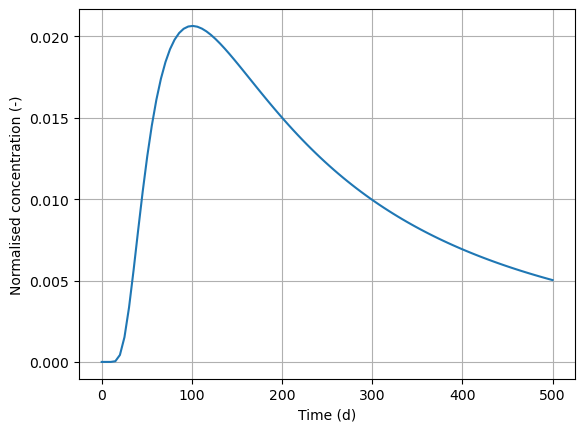

In [2]:
# Example for BTC with point3
from adepy.uniform import point3

c0 = 1000  # injection concentration, mg/L
x = 5
y = 0
z = 0
t = np.linspace(0.001, 500, 100)

v = 0.01  # m/d
n = 0.2  # -
al = 4  # m
ah = 1  # m
av = 1
Q = 1.0  # m^3/d
xc = 0
yc = 0
zc = 0

c = point3(c0, x, y, z, t, v, n, al, ah, av, Q, xc, yc, zc)
c[t > 1] = c[t > 1] - point3(c0, x, y, z, t[t > 1] - 1, v, n, al, ah, av, Q, xc, yc, zc)

plt.plot(t, c / c0)
plt.xlabel("Time (d)")
plt.ylabel("Normalised concentration (-)")
plt.grid()

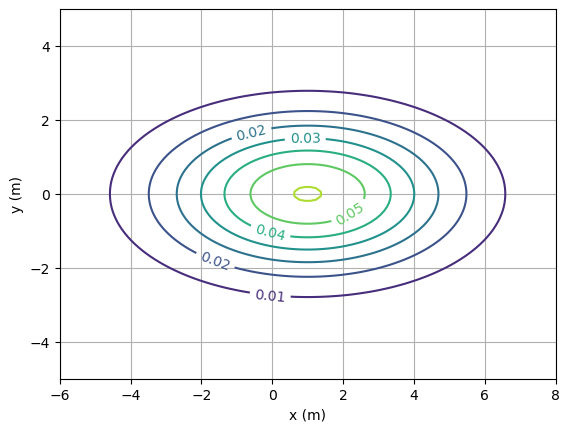

In [3]:
x, y = np.meshgrid(np.linspace(-6, 8, 100), np.linspace(-5, 5, 100))

c = point3(c0, x, y, z, 100, v, n, al, ah, av, Q, xc, yc, zc)
c = c + point3(-c0, x, y, z, 100 - 1, v, n, al, ah, av, Q, xc, yc, zc)

cs = plt.contour(x, y, c / c0)
plt.figaspect(1.0)
plt.clabel(cs, fmt="%.2f")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()

## Source decay

## Chemical reactions

### Linear equilibrium adsorption

### Ion exchange

### First-order decay

### Parent-daughter chain reactions

## Angled flow

## Heat transport